# Analysis

In this notebook, the dataset obtained previously will be analized. We will look for correlations and use k-means ML algorithm in order to group countries with respect to the crucial indicators. <br>
Again, we start with importing libraries and loading the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

joined_df = pd.read_csv('data_joined.csv', index_col = 'country')
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155 entries, afghanistan to zimbabwe
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   surface_area                155 non-null    float64
 1   population                  155 non-null    int64  
 2   population_density          155 non-null    float64
 3   gdp_gross_domestic_product  155 non-null    int64  
 4   gdp_growth_rate             155 non-null    float64
 5   gdp_per_capita              155 non-null    float64
 6   trade_export                155 non-null    float64
 7   trade_import                155 non-null    float64
 8   co2_emission_estimates      155 non-null    int64  
 9   energy_production_primary   155 non-null    float64
 10  capacity_mw                 155 non-null    float64
 11  generation                  155 non-null    float64
 12  generation_biomass          155 non-null    float64
 13  generation_coal          

### Correlations

As the first step, we will examine correlations between datasets columns. To do that, we will arbitrarily divide these columns into x and y subsets.  

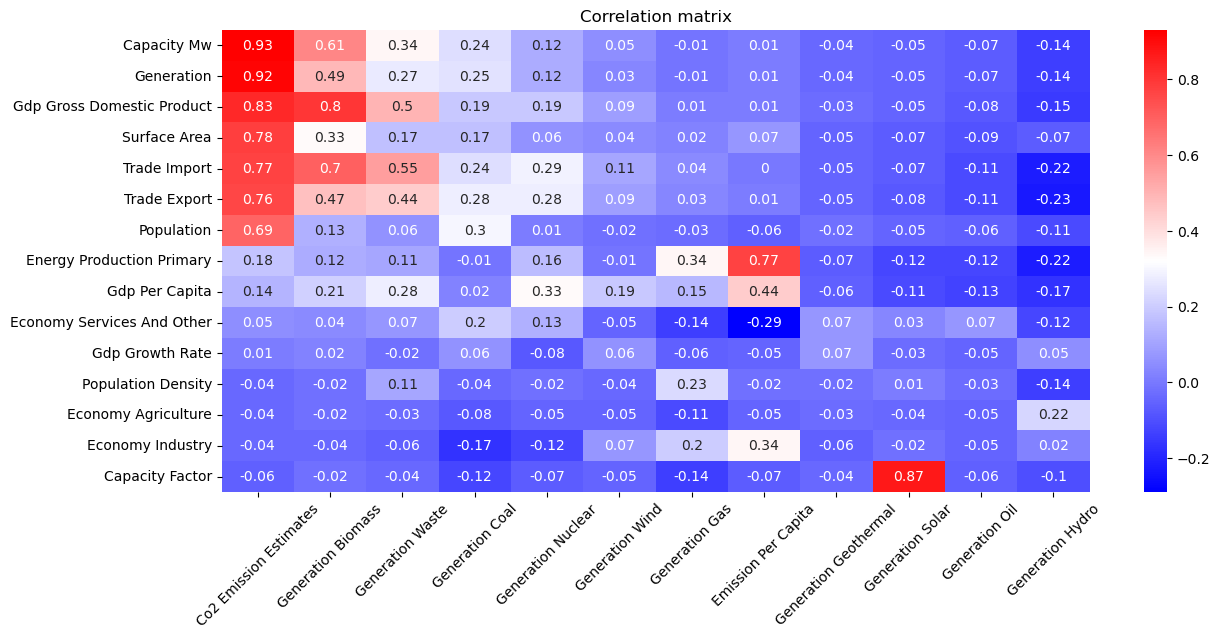

In [10]:
x_ind = [i for i in range(12,22)] + [8, 23]
y_ind = [i for i in range(8)] + [i for i in range(9, 12)] + [i for i in range(24,27)] + [22]

correlations = round(joined_df.corr().iloc[y_ind, x_ind],2)
correlations.sort_values('co2_emission_estimates', axis = 0, inplace = True, ascending = False)
correlations.sort_values('gdp_gross_domestic_product', axis = 1, inplace = True, ascending = False)
correlations.columns = correlations.columns.str.replace('_',' ').str.title()
correlations.index = correlations.index.str.replace('_',' ').str.title() 

plt.figure(figsize = (14,6))
sns.heatmap(correlations, cmap = 'bwr', annot = True)
plt.xticks(rotation = 45)
plt.title('Correlation matrix')
plt.show()

As we can see, there are a few columns that are strongly correlated with each other. What is also interesting, that energy sources are rather weakly correlated with indicators on the y axis. <br>
Let's examin strongly correlated columns dependences on the scatter plots.

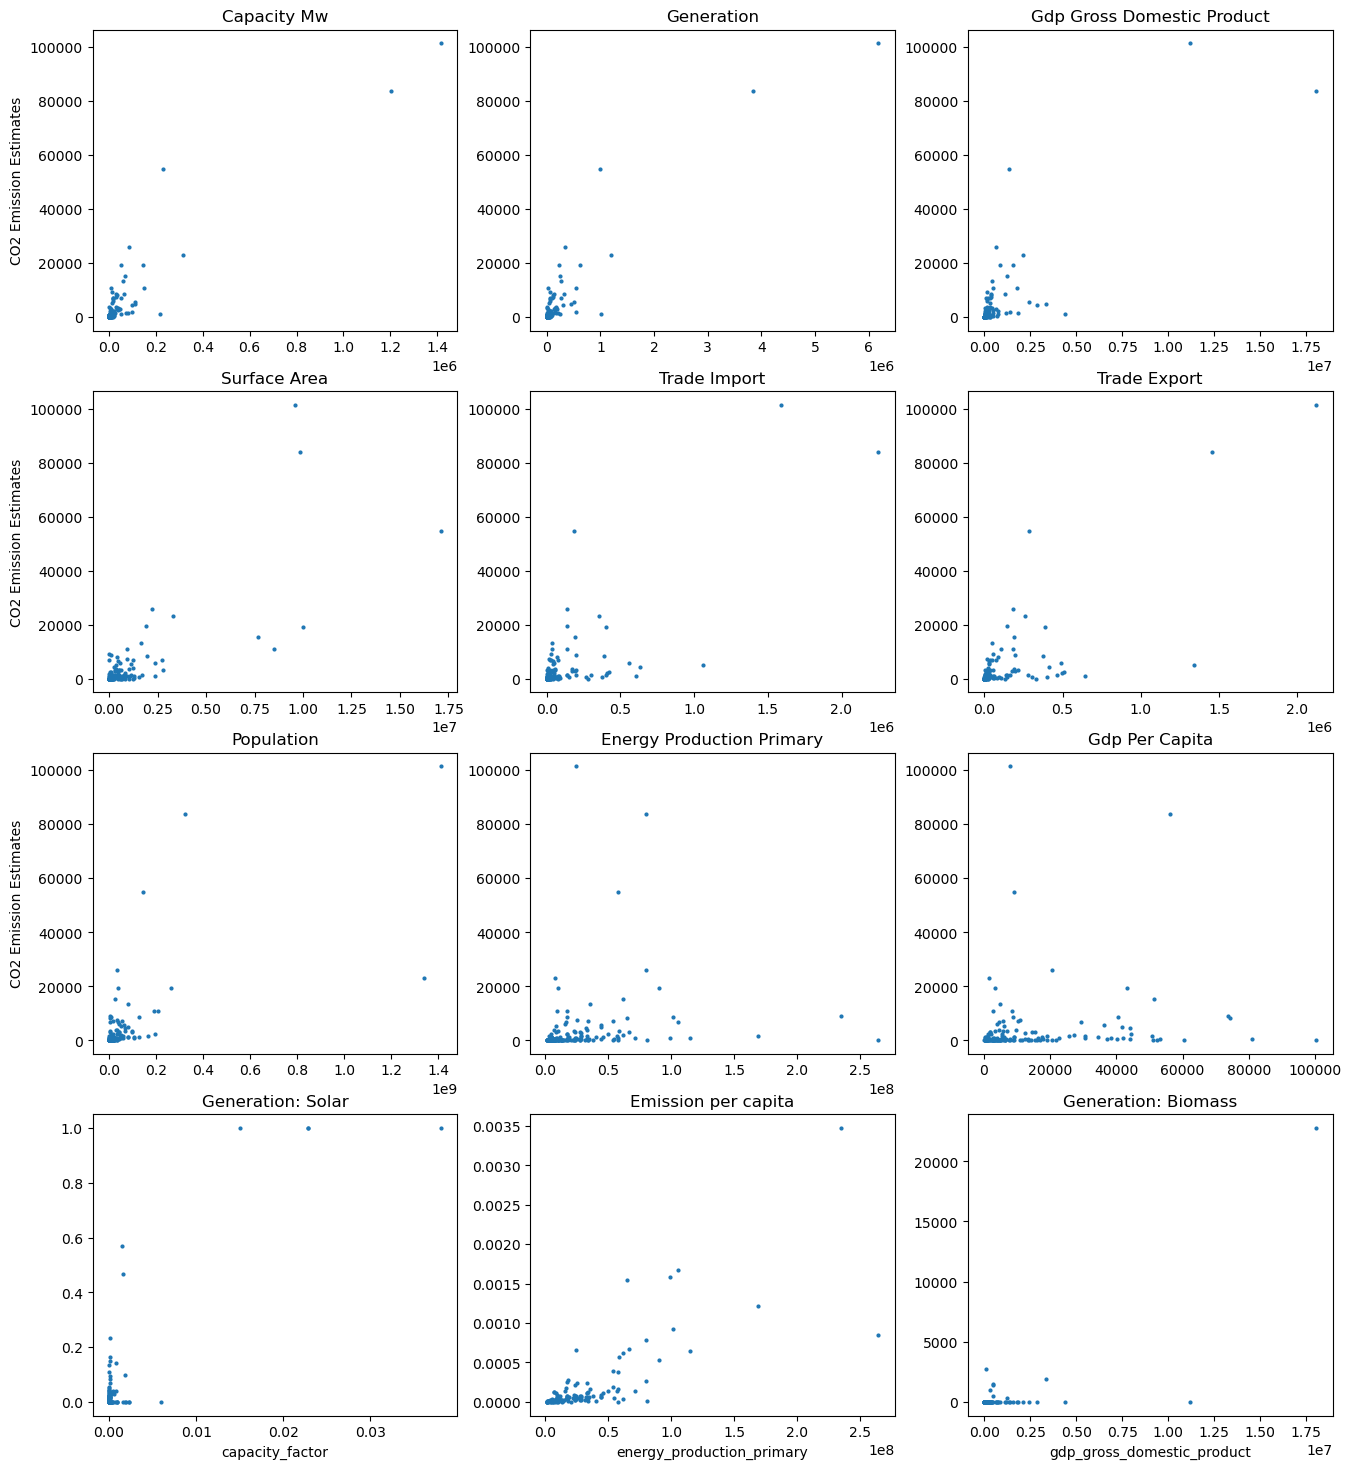

In [16]:
y_cols = correlations.index[:9].str.lower().str.replace(' ','_')

fig, axs = plt.subplots(4,3)
plt.rc('figure', figsize=(16, 18))

for i in range(3):
    for j in range(3):
        joined_df.plot.scatter(x = y_cols[3*i + j], y = 'co2_emission_estimates', ax = axs[i,j], s = 4)
        axs[i,j].set_xlabel('')
        if j > 0:
            axs[i,j].set_ylabel('')
        else:
            axs[i,j].set_ylabel('CO2 Emission Estimates')
        axs[i,j].set_title(y_cols[3*i + j].replace('_',' ').title())
        
joined_df.plot.scatter(x = 'capacity_factor', y = 'generation_solar', ax = axs[3,0], s = 4)
axs[3,0].set_title('Generation: Solar')
axs[3,0].set_ylabel('')
joined_df.plot.scatter(x = 'energy_production_primary', y = 'emission_per_capita', ax = axs[3,1], s = 4)
axs[3,1].set_title('Emission per capita')
axs[3,1].set_ylabel('')
joined_df.plot.scatter(x = 'gdp_gross_domestic_product', y = 'generation_biomass', ax = axs[3,2], s = 4)
axs[3,2].set_title('Generation: Biomass')
axs[3,2].set_ylabel('')
plt.show()

It seems, that high correlation values followed mainly from the fact, that mojaority of the points are accumulated tightly near the low values. In order to take a closer look on those points, we will detect and drop outliners.     

In [44]:
pd.DataFrame({
'CO2 Emission': joined_df.sort_values('co2_emission_estimates', ascending = False).index[:5],
'GDP': joined_df.sort_values('gdp_gross_domestic_product', ascending = False).index[:5],
'Population': joined_df.sort_values('population', ascending = False).index[:5],
'Population Density': joined_df.sort_values('population_density', ascending = False).index[:5]})

,CO2 Emission,GDP,Population,Population Density
0,china,united states of america,china,singapore
1,united states of america,china,india,bahrain
2,russia,japan,united states of america,bangladesh
3,saudi arabia,germany,indonesia,palestine
4,india,united kingdom,brazil,mauritius


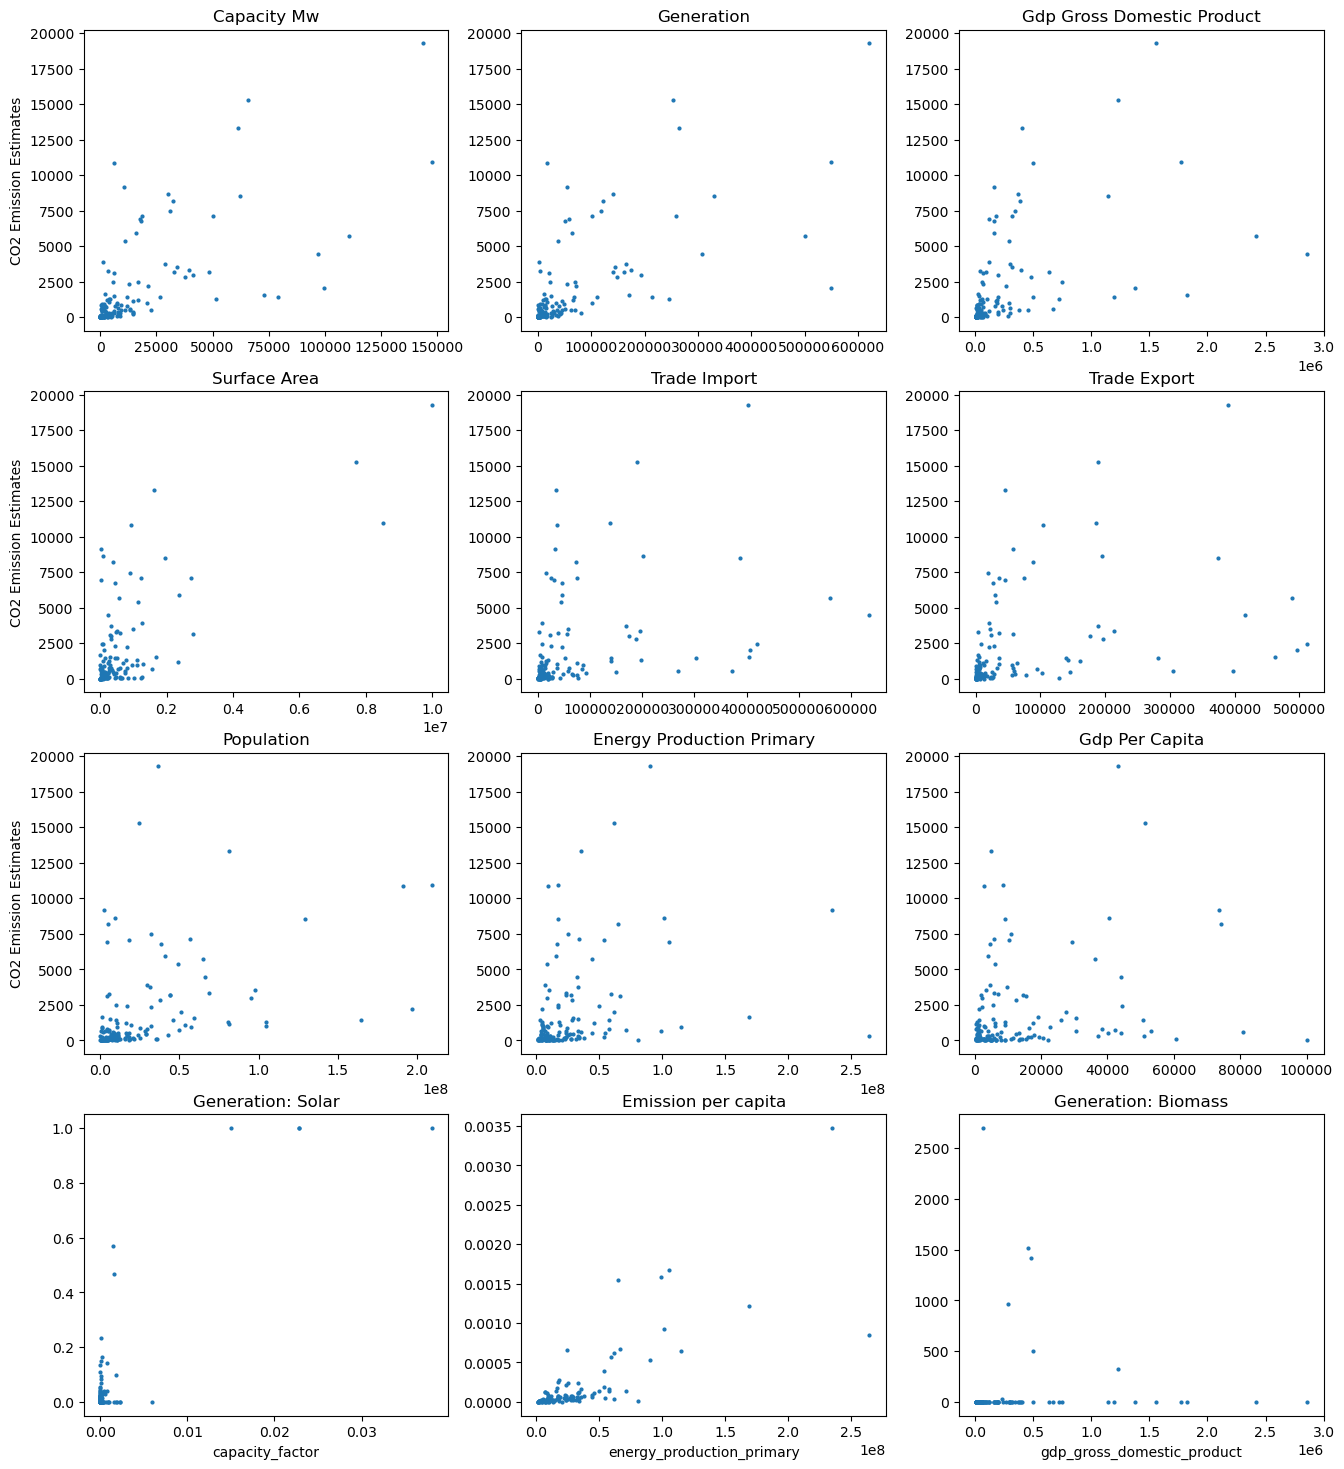

In [48]:
df_shorter = joined_df.drop(['china', 'united states of america', 'russia', 'saudi arabia', 'japan', 'germany', 'indonesia', 'india', 'singapore'], axis = 0)

fig, axs = plt.subplots(4,3)
plt.rc('figure', figsize=(16, 18))

for i in range(3):
    for j in range(3):
        df_shorter.plot.scatter(x = y_cols[3*i + j], y = 'co2_emission_estimates', ax = axs[i,j], s = 4)
        axs[i,j].set_xlabel('')
        if j > 0:
            axs[i,j].set_ylabel('')
        else:
            axs[i,j].set_ylabel('CO2 Emission Estimates')
        axs[i,j].set_title(y_cols[3*i + j].replace('_',' ').title())
        
df_shorter.plot.scatter(x = 'capacity_factor', y = 'generation_solar', ax = axs[3,0], s = 4)
axs[3,0].set_title('Generation: Solar')
axs[3,0].set_ylabel('')
df_shorter.plot.scatter(x = 'energy_production_primary', y = 'emission_per_capita', ax = axs[3,1], s = 4)
axs[3,1].set_title('Emission per capita')
axs[3,1].set_ylabel('')
df_shorter.plot.scatter(x = 'gdp_gross_domestic_product', y = 'generation_biomass', ax = axs[3,2], s = 4)
axs[3,2].set_title('Generation: Biomass')
axs[3,2].set_ylabel('')
plt.show()


Indeed, ifrom visual point of view, high correlation between above columns is doubtful. We can see, however, that on some plots, the datapoints are deployed iin the similar way. Let's examine correlations between y columns.

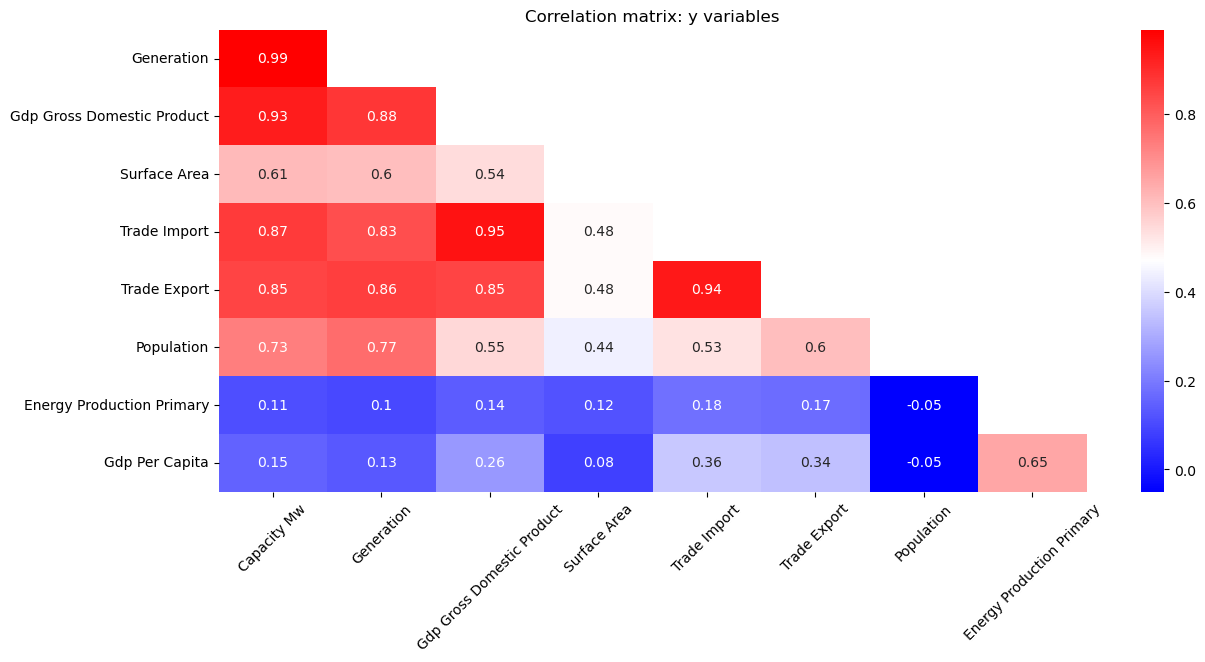

In [47]:
correlations_y = round(joined_df[y_cols].corr(), 2)
for i in range(correlations_y.shape[0]):
    for j in range(correlations_y.shape[1]):
        if j >= i:
            correlations_y.iloc[i, j] = np.nan
correlations_y.drop('capacity_mw', axis = 0, inplace = True)
correlations_y.drop('gdp_per_capita', axis = 1, inplace = True)

correlations_y.columns = correlations_y.columns.str.replace('_',' ').str.title()
correlations_y.index = correlations_y.index.str.replace('_',' ').str.title() 

plt.figure(figsize = (14,6))
sns.heatmap(correlations_y, cmap = 'bwr', annot = True)
plt.xticks(rotation = 45)
plt.title('Correlation matrix: y variables')
plt.show()

Indeed, columns coresponding to similarly looking plots are correlated. <br>
In the next step, we will try to divide countries with respect to their positions on the above plots using KMeans algoritm. In the dataset to be used we will choose only the most important indicators. Also, predictors dataset should be normalized. We will use MinMaxScaler to it, as it will not change the structure of the data, which is not gaussian.

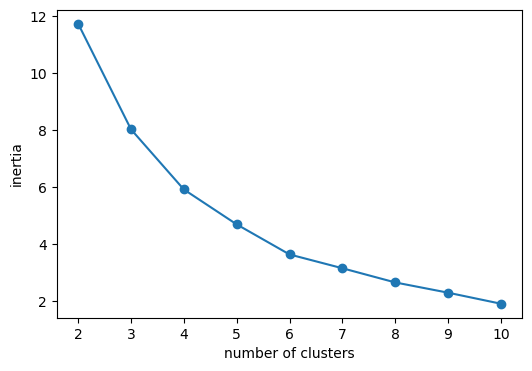

In [51]:
X = joined_df[['co2_emission_estimates', 'gdp_gross_domestic_product', 'generation', 'population']].copy()
X.drop(['russia', 'united states of america', 'china', 'india'], inplace = True)

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns, index = X.index)
X_scaled['co2_emission_estimates'] = 2*X_scaled['co2_emission_estimates']

n = []
inertia = []
for i in range(2,11):
    model = KMeans(n_clusters = i, random_state = 138)
    model.fit(X_scaled)
    n.append(i)
    inertia.append(model.inertia_)
    
plt.figure(figsize = (6,4))
plt.plot(n, inertia, '-o')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.show()

The above plot shows overall inertia of the clusters as a function of number of the clusters. It can be seen, that transition from 6 to 7 clusters does not correspond to significant decrease of the inertia - that is why we will divide datapoints into 6 clusters.

In [31]:
n_clust = 6
model = KMeans(n_clusters = n_clust, random_state = 138)
model.fit(X_scaled)
X.loc[:,'cluster'] = model.predict(X_scaled) + 1

X['cluster'].value_counts()

1    112
2     16
4     10
6      5
5      5
3      3
Name: cluster, dtype: int64

Let's take a look at the clusters division using scatter plots 

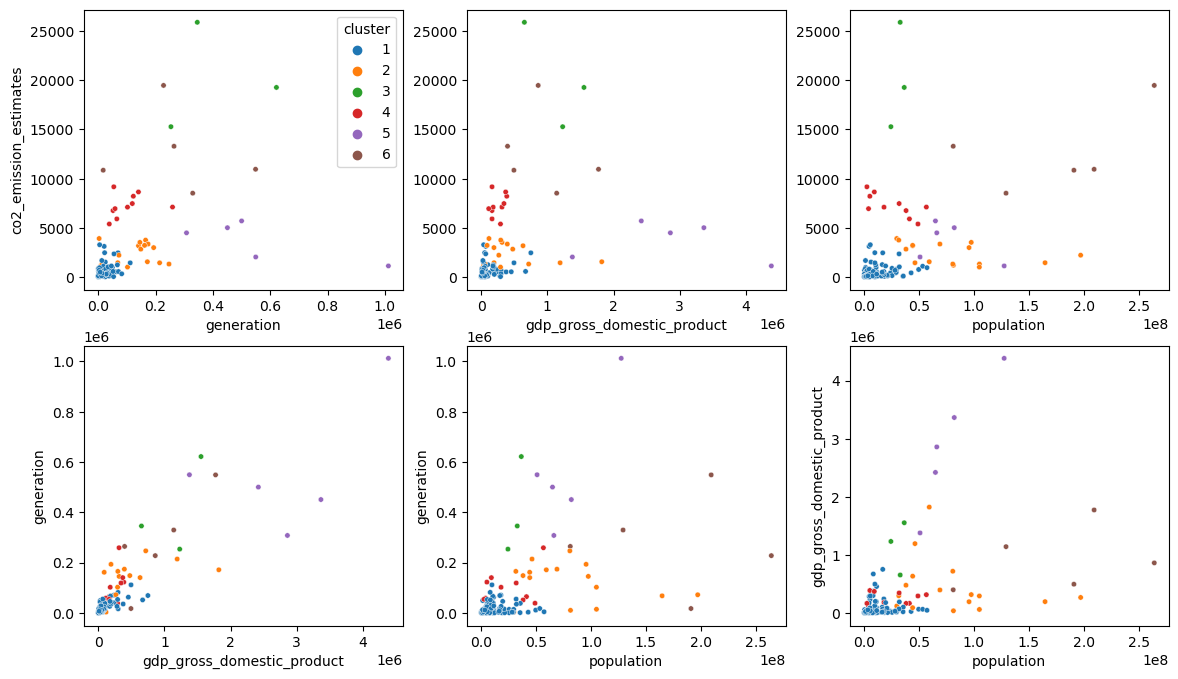

In [32]:
fig, axs = plt.subplots(2,3)
plt.rc('figure', figsize=(14, 8))

sns.scatterplot(data = X, x = 'generation', y = 'co2_emission_estimates', hue = 'cluster', palette = 'tab10', ax = axs[0,0], s = 15)
sns.scatterplot(data = X, x = 'gdp_gross_domestic_product', y = 'co2_emission_estimates', hue = 'cluster', palette = 'tab10', ax = axs[0,1], legend = False, s = 15)
axs[0,1].set_ylabel('')
sns.scatterplot(data = X, x = 'population', y = 'co2_emission_estimates', hue = 'cluster', palette = 'tab10', ax = axs[0,2], legend = False, s = 15)
axs[0,2].set_ylabel('')

sns.scatterplot(data = X, y = 'generation', x = 'gdp_gross_domestic_product', hue = 'cluster', palette = 'tab10', ax = axs[1,0], s = 15, legend = False)
sns.scatterplot(data = X, y = 'generation', x = 'population', hue = 'cluster', palette = 'tab10', ax = axs[1,1], legend = False, s = 15)
sns.scatterplot(data = X, x = 'population', y = 'gdp_gross_domestic_product', hue = 'cluster', palette = 'tab10', ax = axs[1,2], legend = False, s = 15)
plt.show()


It seems, that obtained division looks reasonable. As 5 out of 6 gotten clusters are not very numerous, we can list them.

In [33]:
cluster_series = []
for i in range(1, n_clust + 1):
    cluster_series.append(pd.Series(X[X['cluster'] == i].index, name = str(i)))

clusters = pd.concat(cluster_series, axis = 1)
clusters = clusters.fillna('-')
clusters.iloc[:20]

,1,2,3,4,5,6
0,afghanistan,angola,australia,algeria,france,brazil
1,albania,argentina,canada,colombia,germany,indonesia
2,armenia,bangladesh,saudi arabia,iraq,japan,iran
3,austria,democratic republic of the congo,-,kazakhstan,south korea,mexico
4,azerbaijan,egypt,-,kuwait,united kingdom,nigeria
5,bahrain,ethiopia,-,norway,-,-
6,belarus,italy,-,qatar,-,-
7,belgium,malaysia,-,south africa,-,-
8,benin,pakistan,-,united arab emirates,-,-
9,bhutan,philippines,-,venezuela,-,-


Also, we can plot mean values of the columns used for clustering after grouping predictors set by asigned clusters. On the other hand, standard deviation of these means may be meaningfull.

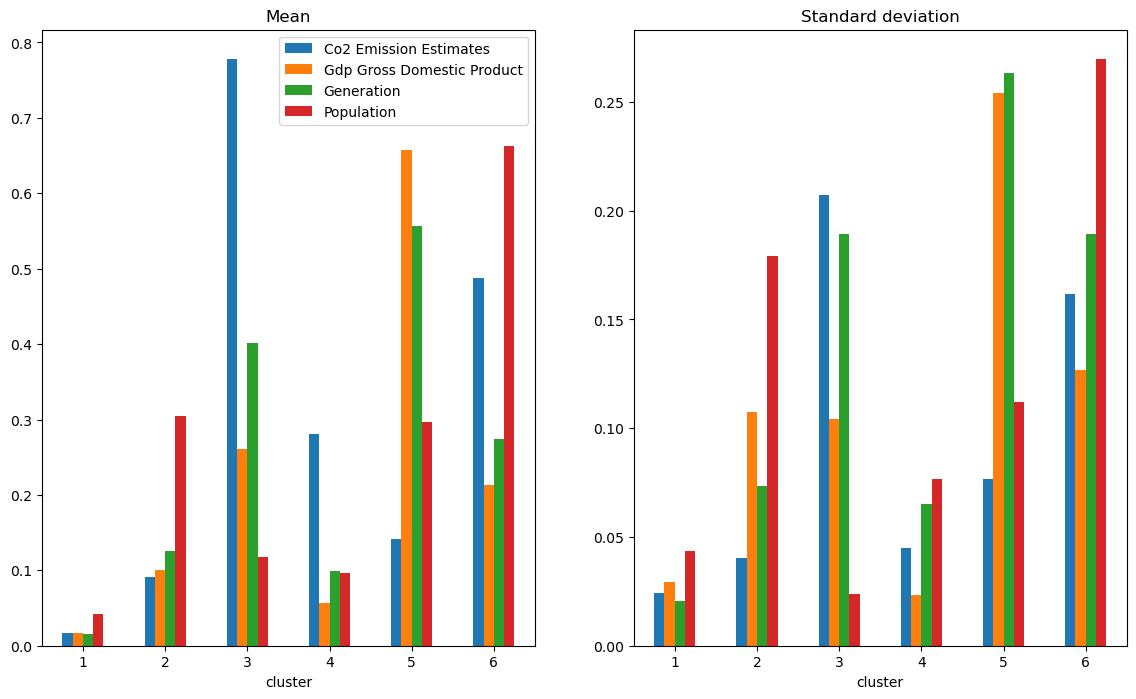

In [34]:
X_norm = X_scaled.iloc[:,:4].join(X[['cluster']])
X_norm['co2_emission_estimates'] = X_scaled['co2_emission_estimates']/2

fig, axs = plt.subplots(1,2)
plt.rc('figure', figsize = (14, 6))

clusters_mean = X_norm.groupby('cluster').mean()
clusters_mean.columns = clusters_mean.columns.str.replace('_', ' ').str.title()
clusters_std = X_norm.groupby('cluster').std()

clusters_mean.plot.bar(rot = 0, ax = axs[0])
axs[0].set_title('Mean')
clusters_std.plot.bar(rot = 0, ax = axs[1], legend = False)
axs[1].set_title('Standard deviation')
plt.show()

<center> <strong>FURTHER DESCRIBTION WILL BE ADDED SOON<strong> <center>

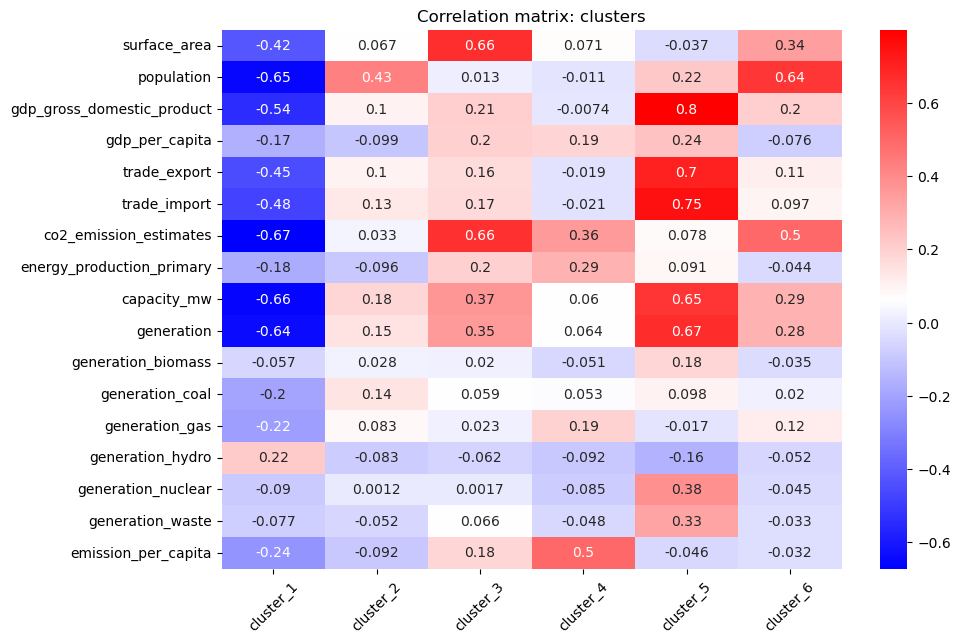

In [35]:
clustered_df = joined_df.drop(['russia', 'united states of america', 'china', 'india'])
clustered_df = clustered_df.join(pd.get_dummies(X['cluster'], prefix = 'cluster'))
correlations_cl = clustered_df.corr().iloc[:-6,-6:]
correlations_cl = correlations_cl[(correlations_cl.max(axis = 1) > 0.15) | (correlations_cl.min(axis = 1) < -0.15)]

plt.figure(figsize = (10,7))
sns.heatmap(correlations_cl, cmap = 'bwr', annot = True)
plt.xticks(rotation = 45)
plt.title('Correlation matrix: clusters')
plt.show()

In [36]:
clustered_df = clustered_df.join(X['cluster']).groupby('cluster').mean()
clustered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1 to 6
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   surface_area                6 non-null      float64
 1   population                  6 non-null      float64
 2   population_density          6 non-null      float64
 3   gdp_gross_domestic_product  6 non-null      float64
 4   gdp_growth_rate             6 non-null      float64
 5   gdp_per_capita              6 non-null      float64
 6   trade_export                6 non-null      float64
 7   trade_import                6 non-null      float64
 8   co2_emission_estimates      6 non-null      float64
 9   energy_production_primary   6 non-null      float64
 10  capacity_mw                 6 non-null      float64
 11  generation                  6 non-null      float64
 12  generation_biomass          6 non-null      float64
 13  generation_coal             6 non-null 

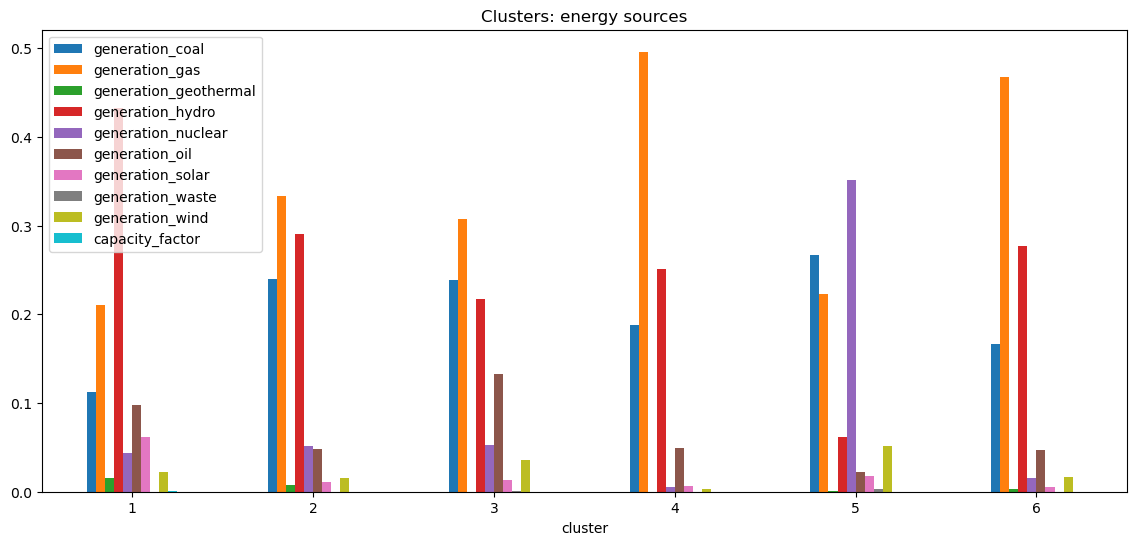

In [41]:
clustered_df.iloc[:,13:23].plot.bar(rot = 0)
plt.title('Clusters: energy sources')
plt.show()

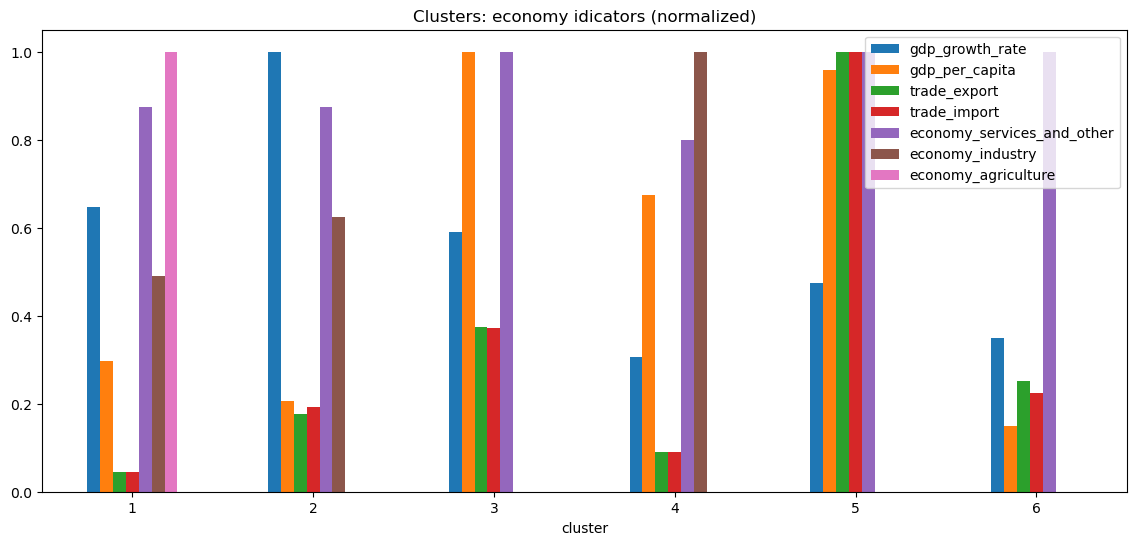

In [43]:
economy_idx = [4,5,6,7,26,25,24]
economy_clustered = clustered_df.iloc[:,economy_idx].copy()

economy_clustered = economy_clustered.apply(lambda x: x/x.max())

economy_clustered.plot.bar(rot = 0)
plt.title('Clusters: economy idicators (normalized)')
plt.show()

## Conclusions